In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/volume-matic-test"

def grt_query(query):
    r = requests.post(GRT_QUERY_ENDPOINT, json={'query': query})
    return r.json()['data']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
fee_query = """
{ pools(first: 1000) {
  isV2
  id
  name
  dailyPoolSnapshots(first: 1000 orderBy: timestamp orderDirection: desc) {
    timestamp
    adminFeesUSD
    lpFeesUSD
    totalDailyFeesUSD
    eventFeesUSD
    baseApr
    tvl
  }
}
}
"""

In [3]:
data = grt_query(fee_query)['pools']
df = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df['totalDailyFeesUSD'] = df['totalDailyFeesUSD'].astype(float)
df['eventFeesUSD'] = df['eventFeesUSD'].astype(float) * 2
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df = df.sort_values('timestamp', ascending=True)
df

,isV2,id,name,timestamp,adminFeesUSD,lpFeesUSD,totalDailyFeesUSD,eventFeesUSD,baseApr,tvl
5928,False,0x445fe580ef8d70ff569ab36e80c647af338db351,Curve.fi amDAI/amUSDC/amUSDT,2021-05-02,0,0,0.00,0.00,0,220147555.465170900532559201
5927,False,0x445fe580ef8d70ff569ab36e80c647af338db351,Curve.fi amDAI/amUSDC/amUSDT,2021-05-03,31971.54755006249478086788055741232,31971.54755006249478086788055741232,63943.10,0.00,0.0001242052006398339929592103131480798,257409089.0346250359876306681059915
5926,False,0x445fe580ef8d70ff569ab36e80c647af338db351,Curve.fi amDAI/amUSDC/amUSDT,2021-05-04,58192.54133678538992061354081793326,58192.54133678538992061354081793324,116385.08,0.00,0.0002237222637709756181174661890010285,260110640.5590329114303795093493721
5925,False,0x445fe580ef8d70ff569ab36e80c647af338db351,Curve.fi amDAI/amUSDC/amUSDT,2021-05-05,45405.11436440960183665385907998404,45405.11436440960183665385907998404,90810.23,0.00,0.0001651559037716909806897356868275621,274922744.6763086596031594380523188
5924,False,0x445fe580ef8d70ff569ab36e80c647af338db351,Curve.fi amDAI/amUSDC/amUSDT,2021-05-06,46895.83315674247311529434585885425,46895.83315674247311529434585885425,93791.67,0.00,0.0001735265371016202466485850822420314,270251651.0732847372851092942083257
...,...,...,...,...,...,...,...,...,...,...
21622,False,0xfe18100f0ce7c1b771366f58e6dc58d1ecb0409c,Curve.fi Factory Plain Pool: mim,2022-04-21,0,0,0.00,0.00,0,0
8066,False,0x64fff0e27c223097c824f9d9278efd5b55c3430e,Curve.fi Factory Plain Pool: WMATIC/ALERTO,2022-04-21,0,0,0.00,0.00,0,0.000002469532883810907017416540291693656
11007,False,0x8a95282517721cb7bbc539b8834073198e35ad07,Curve.fi Factory Plain Pool: OMI/wOMI (PoS/Wor...,2022-04-21,0,0,0.00,0.00,0,0
15576,False,0xb9fb6e86978f3eedcc1184b25cf45613bb448ef7,Curve.fi Factory USD Metapool: ETH/USDC,2022-04-21,0,0,0.00,0.00,0,0


<AxesSubplot:xlabel='timestamp'>

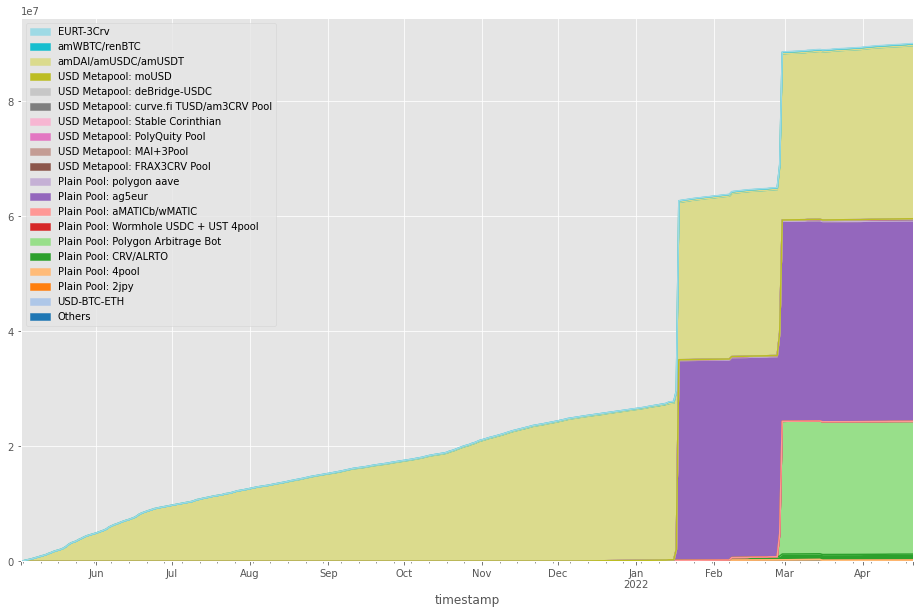

In [4]:
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data = df[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name')
top_performers = chart_data.mean().sort_values(ascending=False)[:19].index.tolist()
df_others = df.copy()
df_others['name'] = df_others['name'].apply(lambda x: x if x in top_performers else 'Others')
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data_others = df_others[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name')
chart_data_others['Others'] = df_others[df_others['name'] == 'Others'][['timestamp', 'cumulativeDailyFeesUSD']].groupby('timestamp').sum()['cumulativeDailyFeesUSD']
chart_data_others.columns = [s.replace('Curve.fi Factory ', '').replace('Curve.fi ', '').replace('Curve ', '') for s in chart_data_others.columns]
cols = chart_data_others.columns.tolist()
chart_data_others[([cols[-1], *cols[1:-1], cols[0]])].plot.area(figsize=(16, 10), legend='reverse', colormap="tab20")

In [5]:
WEEK = 3600 * 24 * 7
df_week = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df_week['totalDailyFeesUSD'] = df_week['totalDailyFeesUSD'].astype(float)
df_week['timestamp'] = df_week['timestamp'].apply(lambda x: ((int(x) // WEEK) * WEEK))
df_week['timestamp'] = pd.to_datetime(df_week['timestamp'],unit='s')
df_week = df_week.sort_values('timestamp', ascending=True)
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum()

,totalDailyFeesUSD
timestamp,
2021-04-29,271138.41
2021-05-06,866150.66
2021-05-13,1138309.30
2021-05-20,1674303.77
2021-05-27,1130419.65
2021-06-03,1412733.58
2021-06-10,1105819.29
2021-06-17,1386378.91
2021-06-24,671569.10


In [6]:
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum().sum() / 2

totalDailyFeesUSD   45159460.11
dtype: float64